#PROJECT - STORE SALES FORECASTING

**Objective**
1. Memahami data yang digunakan, bagaimana melihat data, melakukan visualisasi hingga memahami karakteristik time series data.
2. Melakukan process data, seperti cleaning, transformasi, hingga feature engineering.
3. Melakukan pemodelan menggunakan ARIMA dan LSTM.
4. Melakukan evaluasi model yang telah dibuat.
5. Menarik kesimpulan dari hasil analisis yang telah dilakukan.

**TERMS**

*   ARIMA : Autoregressive Integrated Moving Average, model statistik yang digunakan dalam analisis data time series.
*   LSTM : Long Short Term Memory, model neural network yang digunakan dalam analisis data time series.
* Time Series : Data yang terurut berdasarkan waktu.
* Forecasting : Proses memprediksi nilai di masa depan berdasarkan data masa lalu.




In [41]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.impute import KNNImputer


# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

**Data Preparation**
Proses ini meliputi:
1. Load Data
2. Cek data
3. Cleaning data

In [5]:
df_train = pd.read_csv('store5.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,1/1/2013,5,AUTOMOTIVE,0.000,0,NaN
1,1453,1/1/2013,5,BABY CARE,0.000,0,NaN
2,1454,1/1/2013,5,BEAUTY,0.000,0,NaN
3,1455,1/1/2013,5,BEVERAGES,0.000,0,NaN
4,1456,1/1/2013,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,8/15/2017,5,POULTRY,241.011,1,47.57
55568,3000587,8/15/2017,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,8/15/2017,5,PRODUCE,1357.823,4,47.57
55570,3000589,8/15/2017,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [6]:
#memeriksa data Null pada kolom
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

In [7]:
#memeriksa jumlah data pada setiap kolom
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

In [8]:
df_train.describe()

,id,store_nbr,sales,onpromotion,dcoilwtico
count,5.557200e+04,55572.0,55572.000000,55572.000000,38379.000000
mean,1.501021e+06,5.0,280.580231,2.687864,67.925589
std,8.662894e+05,0.0,652.588149,11.748996,25.666659
min,1.452000e+03,5.0,0.000000,0.000000,26.190000
25%,7.512365e+05,5.0,1.000000,0.000000,46.380000
50%,1.501021e+06,5.0,19.000000,0.000000,53.330000
75%,2.250806e+06,5.0,237.000000,0.000000,95.800000
max,3.000590e+06,5.0,8216.620000,182.000000,110.620000


In [9]:
# hapus kolom id dan store_nbr
df_train.drop(['id', 'store_nbr'], axis=1, inplace=True)
df_copy = df_train.copy()
# Mengubah tipe data kolom date menjadi datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Mengurutkan data berdasarkan tanggal
df_train = df_train.set_index('date')
df_train

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.000,0,NaN
2013-01-01,BABY CARE,0.000,0,NaN
2013-01-01,BEAUTY,0.000,0,NaN
2013-01-01,BEVERAGES,0.000,0,NaN
2013-01-01,BOOKS,0.000,0,NaN
...,...,...,...,...
2017-08-15,POULTRY,241.011,1,47.57
2017-08-15,PREPARED FOODS,52.121,0,47.57
2017-08-15,PRODUCE,1357.823,4,47.57


In [10]:
#Ingin mengetahui data penjualan untuk family Meats
meats = df_train['family']=='MEATS'
meats = df_train[meats]
meats

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,MEATS,0.00000,0,NaN
2013-01-02,MEATS,455.39902,0,93.14
2013-01-03,MEATS,352.64200,0,92.97
2013-01-04,MEATS,407.36400,0,93.12
2013-01-05,MEATS,466.82500,0,NaN
...,...,...,...,...
2017-08-11,MEATS,327.28000,34,48.81
2017-08-12,MEATS,234.64400,0,NaN
2017-08-13,MEATS,241.69600,0,NaN


In [11]:
meats.describe()

,sales,onpromotion,dcoilwtico
count,1684.000000,1684.000000,1163.000000
mean,283.316157,3.960214,67.925589
std,69.929308,10.049324,25.677366
min,0.000000,0.000000,26.190000
25%,235.534500,0.000000,46.390000
50%,276.415000,0.000000,53.330000
75%,327.490250,1.000000,95.790000
max,576.433000,38.000000,110.620000


In [12]:
#Ingin mengetahui data penjualan untuk family Pet Supplies
pet_supplies = df_train[df_train['family'] == 'PET SUPPLIES']
print(pet_supplies)

                  family  sales  onpromotion  dcoilwtico
date                                                    
2013-01-01  PET SUPPLIES    0.0            0         NaN
2013-01-02  PET SUPPLIES    0.0            0       93.14
2013-01-03  PET SUPPLIES    0.0            0       92.97
2013-01-04  PET SUPPLIES    0.0            0       93.12
2013-01-05  PET SUPPLIES    0.0            0         NaN
...                  ...    ...          ...         ...
2017-08-11  PET SUPPLIES    7.0            0       48.81
2017-08-12  PET SUPPLIES    3.0            0         NaN
2017-08-13  PET SUPPLIES    3.0            0         NaN
2017-08-14  PET SUPPLIES    0.0            0       47.59
2017-08-15  PET SUPPLIES    4.0            0       47.57

[1684 rows x 4 columns]


In [13]:
pet_supplies.describe()

,sales,onpromotion,dcoilwtico
count,1684.000000,1684.000000,1163.000000
mean,1.899644,0.024941,67.925589
std,2.331428,0.155990,25.677366
min,0.000000,0.000000,26.190000
25%,0.000000,0.000000,46.390000
50%,1.000000,0.000000,53.330000
75%,3.000000,0.000000,95.790000
max,15.000000,1.000000,110.620000


#EDA (EXPLORATORY DATA ANALYSIS)

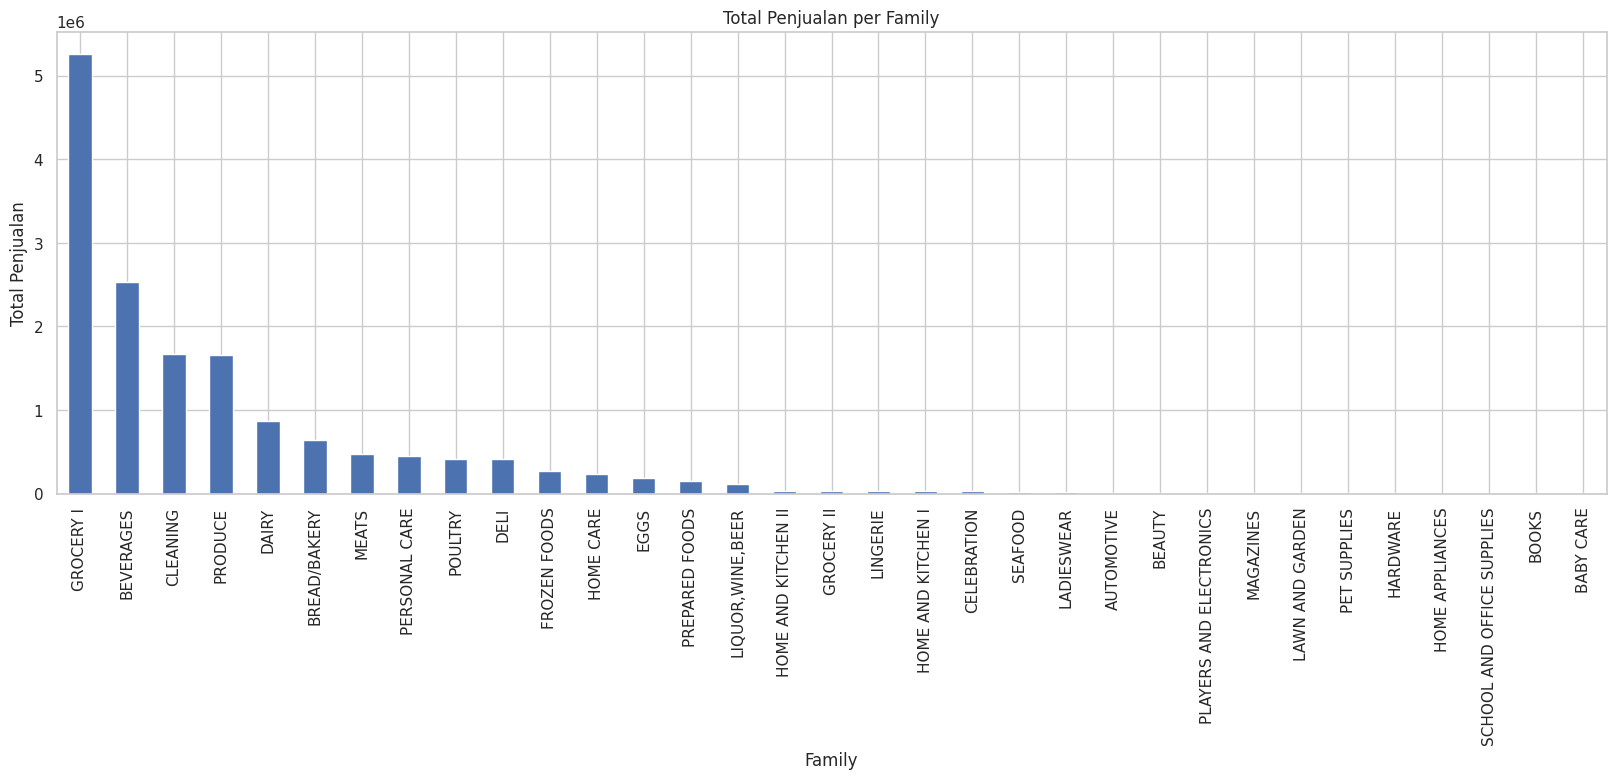

In [14]:
# plot data total penjualan berdasarkan family
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

# Gunakan fungsi groupby dan sum untuk menghitung total penjualan per family
df_train.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per Family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show()

In [15]:
# Total penjualan per family
df_train.groupby('family')['sales'].sum().sort_values(ascending=False)

family
GROCERY I                     5.262682e+06
BEVERAGES                     2.533831e+06
CLEANING                      1.667748e+06
PRODUCE                       1.653582e+06
DAIRY                         8.712830e+05
BREAD/BAKERY                  6.428546e+05
MEATS                         4.771044e+05
PERSONAL CARE                 4.501660e+05
POULTRY                       4.196304e+05
DELI                          4.152710e+05
FROZEN FOODS                  2.696692e+05
HOME CARE                     2.392830e+05
EGGS                          1.908510e+05
PREPARED FOODS                1.479911e+05
LIQUOR,WINE,BEER              1.104140e+05
HOME AND KITCHEN II           3.723800e+04
GROCERY II                    3.324100e+04
LINGERIE                      3.156100e+04
HOME AND KITCHEN I            3.010700e+04
CELEBRATION                   2.617600e+04
SEAFOOD                       2.235899e+04
LADIESWEAR                    1.481300e+04
AUTOMOTIVE                    9.194000e+03
BEAU

<Figure size 2000x600 with 0 Axes>

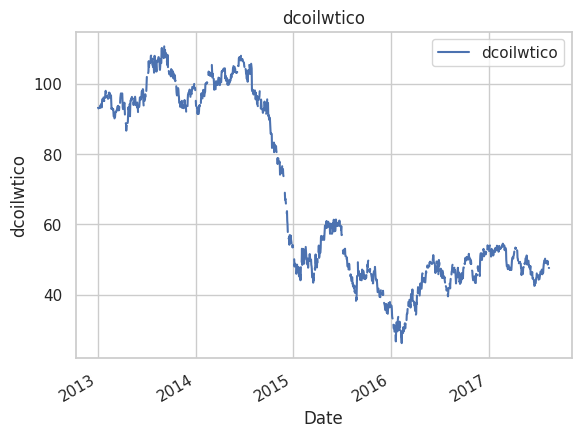

In [16]:
# Melihat dcoilwtico
# Membuat dcoilwitco menjadi dataset terpisah, lalu mengubah indexnya
# take dcoilwitco based on date
dcoilwtico = df_train['family']=='MEATS'
dcoilwtico = df_train[dcoilwtico]
# Only take date and dcoilwtico
dcoilwtico = dcoilwtico[['dcoilwtico']]

# Plot dcoilwtico
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
dcoilwtico.plot()
plt.title('dcoilwtico')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.show()

<Figure size 2000x600 with 0 Axes>

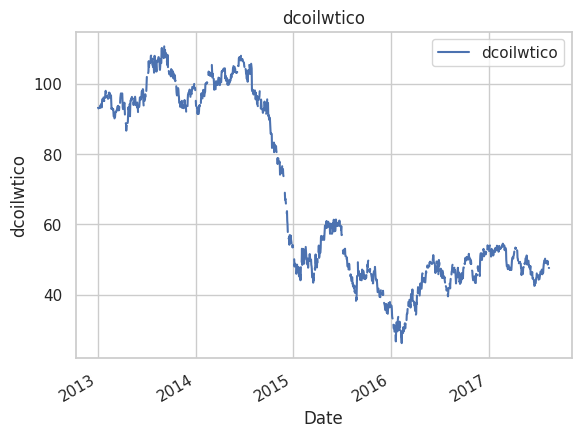

In [17]:
# Melihat dcoilwtico
# Membuat dcoilwitco menjadi dataset terpisah, lalu mengubah indexnya
# take dcoilwitco based on date
dcoilwtico = df_train['family']=='PET SUPPLIES'
dcoilwtico = df_train[dcoilwtico]
# Only take date and dcoilwtico
dcoilwtico = dcoilwtico[['dcoilwtico']]

# Plot dcoilwtico
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
dcoilwtico.plot()
plt.title('dcoilwtico')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.show()

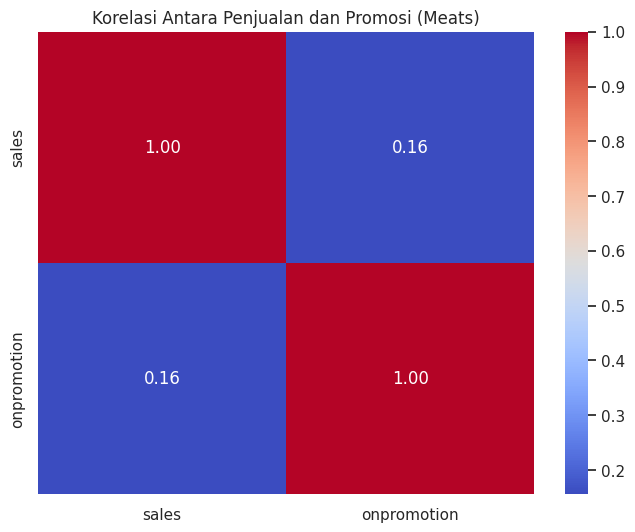

In [18]:
def plot_sales_promotion_correlation_heatmap(df):
    # Filter data untuk kategori "Meats"
    meats_data = df[df['family'] == 'MEATS']

    # Hitung korelasi antara penjualan dan promosi
    correlation = meats_data[['sales', 'onpromotion']].corr()

    # Buat heatmap korelasi
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Korelasi Antara Penjualan dan Promosi (Meats)')
    plt.show()

# Gunakan fungsi untuk membuat heatmap korelasi
plot_sales_promotion_correlation_heatmap(df_train)

In [19]:
df= df_train.loc[(df_train['family'] == 'PET SUPPLIES') | (df_train['family'] == 'MEATS')]


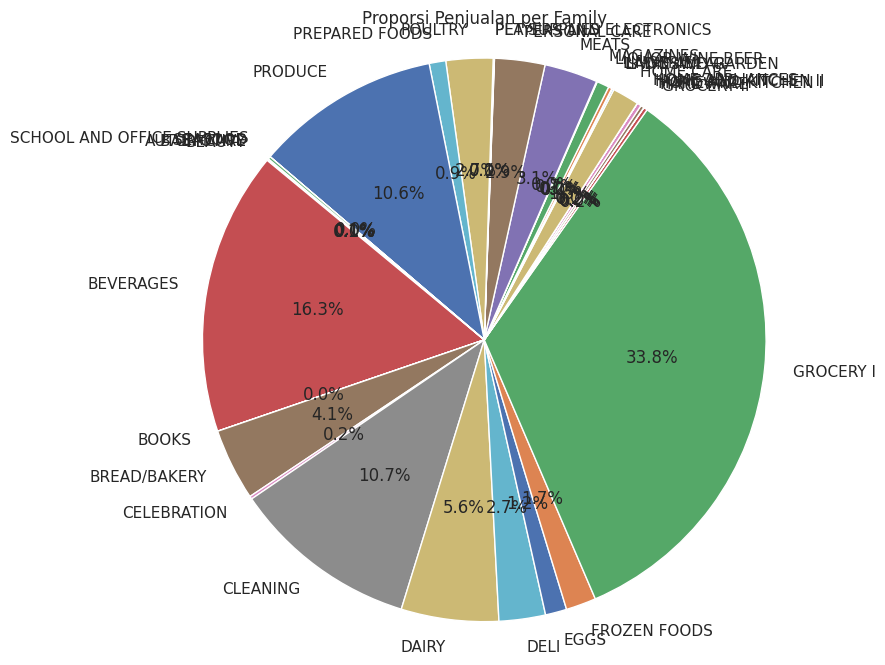

In [20]:
def plot_sales_proportion_pie_chart(df):
    # Hitung total penjualan per kategori (family)
    sales_per_family = df.groupby('family')['sales'].sum()

    # Buat pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sales_per_family, labels=sales_per_family.index, autopct='%1.1f%%', startangle=140)
    plt.title('Proporsi Penjualan per Family')
    plt.axis('equal')  # Mengatur aspek lingkaran agar berbentuk lingkaran
    plt.show()

# Gunakan fungsi untuk membuat pie chart
plot_sales_proportion_pie_chart(df_train)

#EDA PER FAMILY


In [21]:
#Ingin mengetahui data penjualan untuk family Meats
meats = df_train['family']=='MEATS'
meats = df_train[meats]
meats

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,MEATS,0.00000,0,NaN
2013-01-02,MEATS,455.39902,0,93.14
2013-01-03,MEATS,352.64200,0,92.97
2013-01-04,MEATS,407.36400,0,93.12
2013-01-05,MEATS,466.82500,0,NaN
...,...,...,...,...
2017-08-11,MEATS,327.28000,34,48.81
2017-08-12,MEATS,234.64400,0,NaN
2017-08-13,MEATS,241.69600,0,NaN


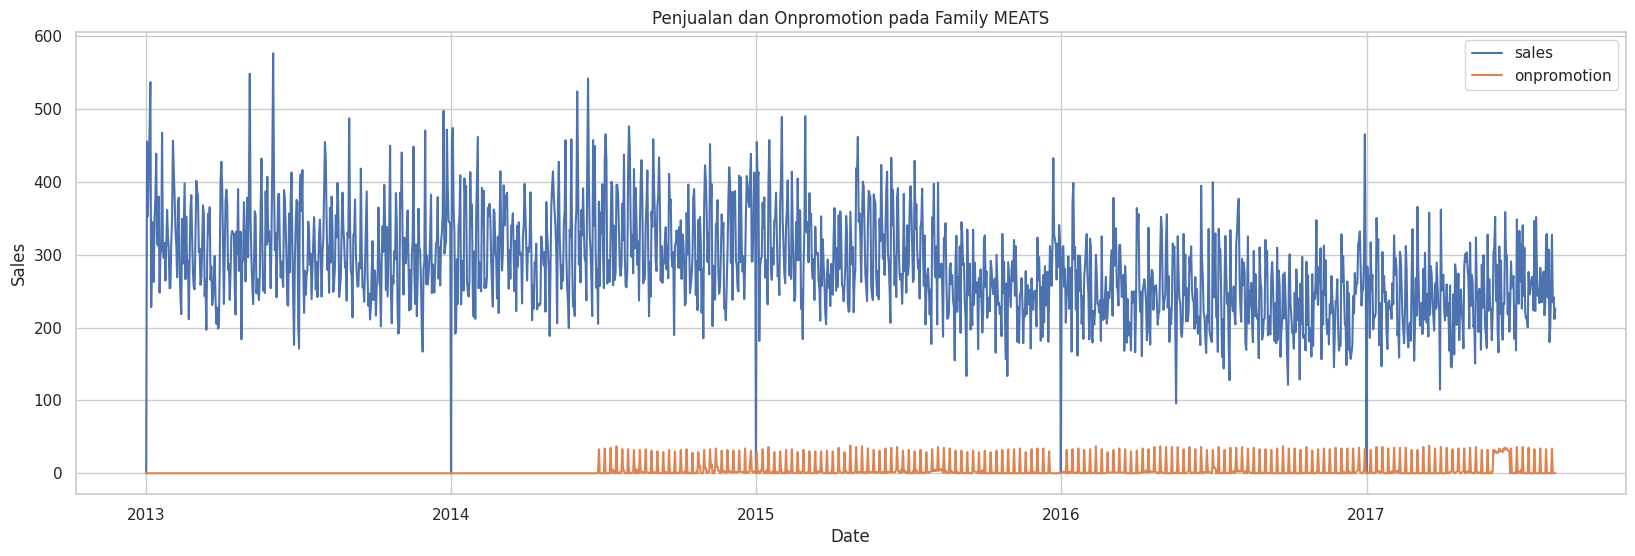

In [22]:
# Melihat penjualan dan onpromotion pada family MEATS
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=meats, x='date', y='sales', label='sales')
sns.lineplot(data=meats, x='date', y='onpromotion', label='onpromotion')
plt.title('Penjualan dan Onpromotion pada Family MEATS')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='date'>

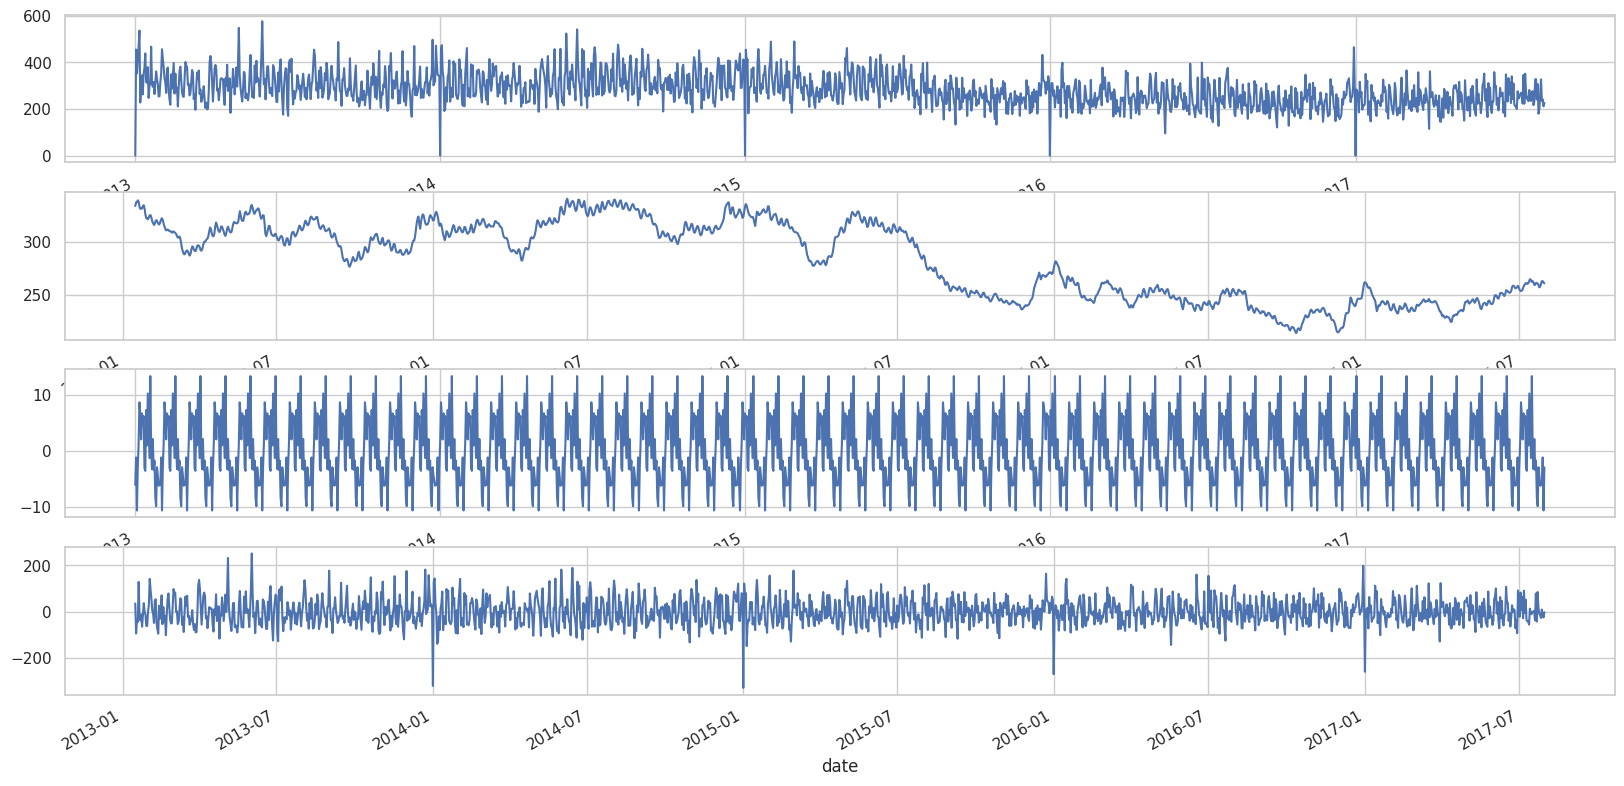

In [23]:
# Decompose data transactions
plot_decompose = seasonal_decompose(meats['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [24]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(meats['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.876441
p-value: 0.048157


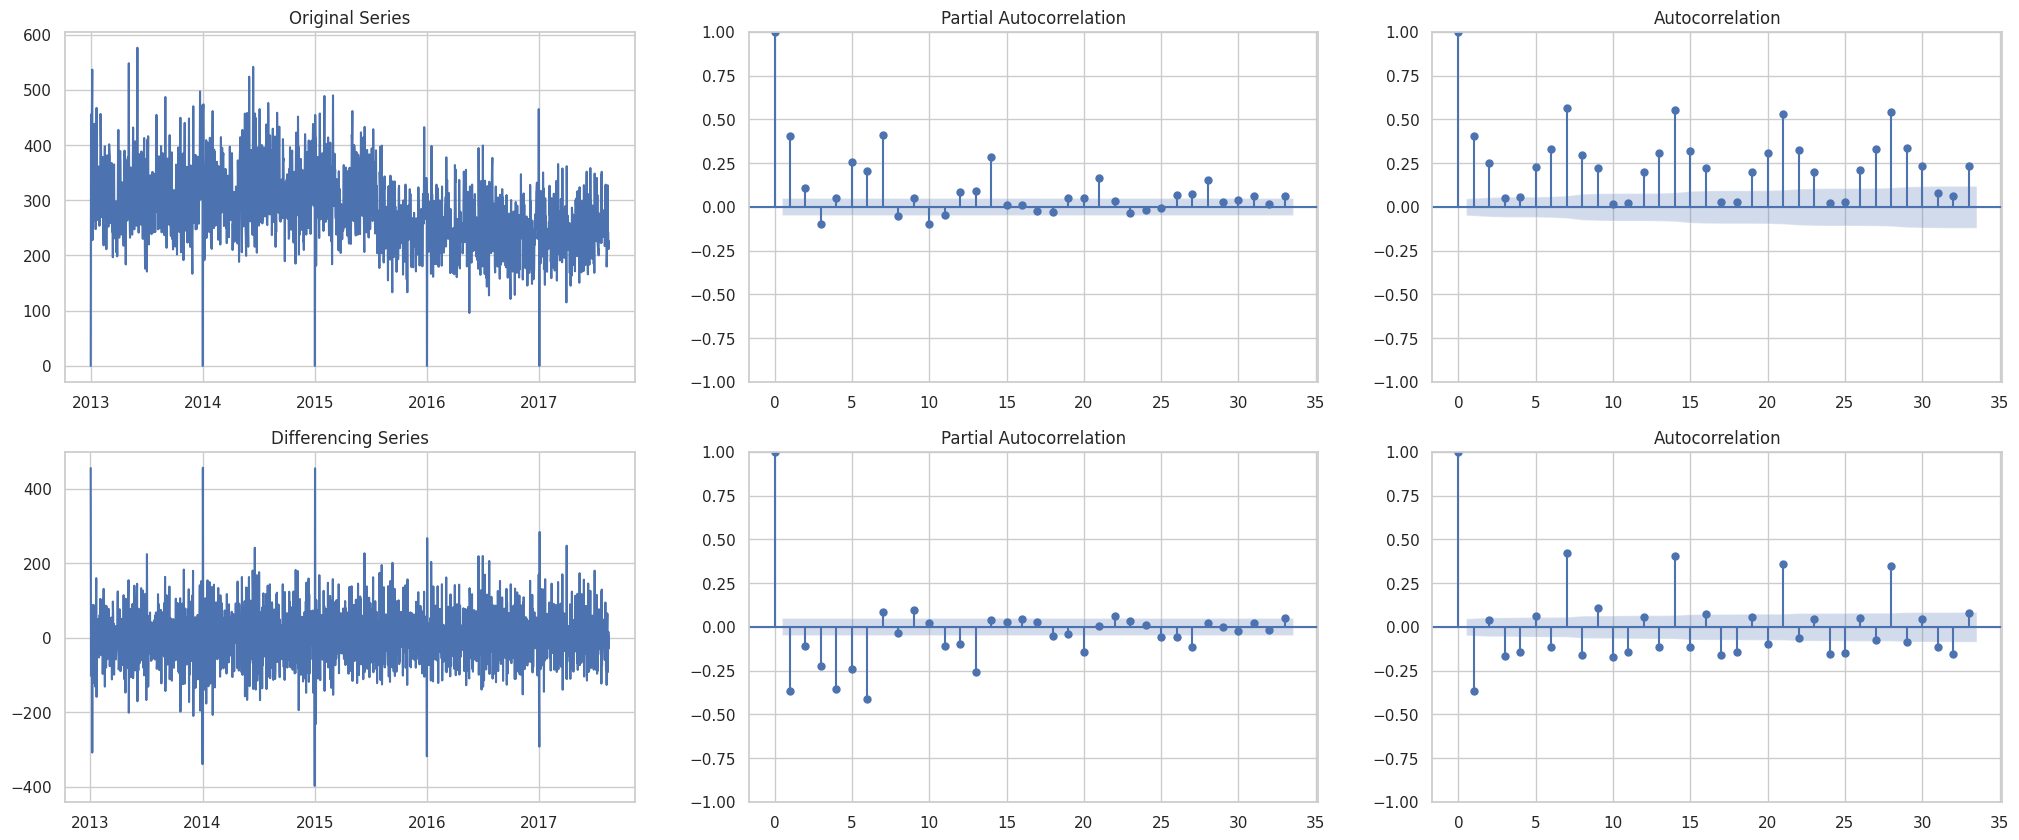

In [25]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(meats['sales'])
ax[0, 1] = plot_pacf(meats['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(meats['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(meats['sales'].diff().dropna())
ax[1, 1] = plot_pacf(meats['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(meats['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

#FEATURE ENGINEERING

In [26]:
df = df_train.loc[(df_train['family'] == 'PET SUPPLIES') | (df_train['family'] == 'MEATS')]


In [27]:
df.drop(['family','dcoilwtico','onpromotion'], axis=1, inplace=True)


In [28]:
# Mengganti nilai 0 dengan NaN
df.replace(0, np.nan, inplace=True)

In [44]:
knn_imputer = KNNImputer(n_neighbors=5)

df = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


In [45]:
df

,sales
date,
2013-01-01,184.945479
2013-01-01,184.945479
2013-01-02,455.399020
2013-01-02,184.945479
2013-01-03,352.642000
...,...
2017-08-13,3.000000
2017-08-14,211.646000
2017-08-14,184.945479


#LSTM

In [46]:
# Normalisasi data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [47]:
# Membuat sequences
sequence_length = 10

In [48]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


In [49]:
X, y = create_sequences(scaled_data, sequence_length)

In [50]:
from sklearn.model_selection import train_test_split
# Split data menjadi training dan validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Flatten
from keras.optimizers import RMSprop
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=df.shape[1]))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

In [52]:
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [53]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/100
54/54 [==============================] - 5s 44ms/step - loss: 0.0481 - mae: 0.1817 - val_loss: 0.0395 - val_mae: 0.1688
Epoch 2/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0402 - mae: 0.1719 - val_loss: 0.0406 - val_mae: 0.1681
Epoch 3/100
54/54 [==============================] - 1s 26ms/step - loss: 0.0392 - mae: 0.1703 - val_loss: 0.0392 - val_mae: 0.1715
Epoch 4/100
54/54 [==============================] - 1s 26ms/step - loss: 0.0379 - mae: 0.1673 - val_loss: 0.0371 - val_mae: 0.1661
Epoch 5/100
54/54 [==============================] - 1s 27ms/step - loss: 0.0379 - mae: 0.1668 - val_loss: 0.0375 - val_mae: 0.1601
Epoch 6/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0364 - mae: 0.1627 - val_loss: 0.0421 - val_mae: 0.1755
Epoch 7/100
54/54 [==============================] - 2s 27ms/step - loss: 0.0353 - mae: 0.1597 - val_loss: 0.0377 - val_mae: 0.1654
Epoch 8/100
54/54 [==============================] - 1s 25ms/step - loss: 0.

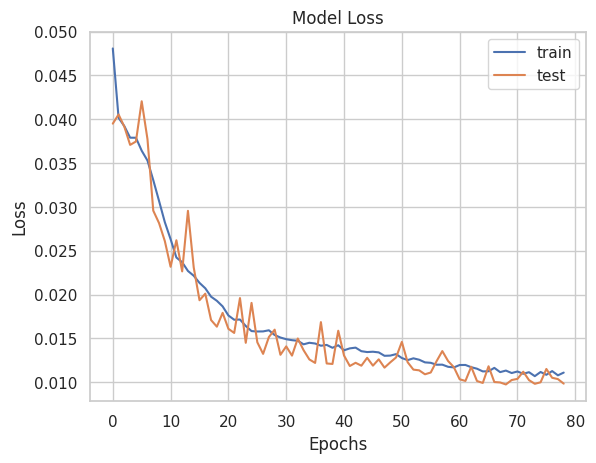

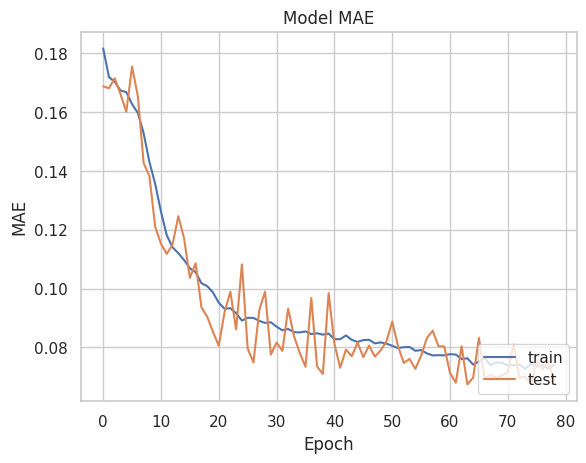

In [54]:
# Plot akurasi dan loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [55]:
predictions = model.predict(X_val)

21/21 [==============================] - 1s 7ms/step


In [56]:
last_sequence = scaled_data[-sequence_length:]
forecast_periods = 120
forecast = []

In [57]:
for _ in range(forecast_periods):
    last_sequence = last_sequence.reshape((1, sequence_length, df.shape[1]))

    next_pred = model.predict(last_sequence)

    forecast.append(next_pred[0])

    last_sequence = np.concatenate([last_sequence[0][1:], next_pred], axis=0)

1/1 [==============================] - 0s 32ms/step


In [58]:
df.tail()

,sales
date,
2017-08-13,3.000000
2017-08-14,211.646000
2017-08-14,184.945479
2017-08-15,226.199000
2017-08-15,4.000000


In [59]:
forecast = scaler.inverse_transform(forecast)

forecast_index = pd.date_range(start='2017-08-16', periods=forecast_periods)

In [60]:
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df.columns)
forecast_df.tail()

,sales
2017-12-09,43.646657
2017-12-10,279.296766
2017-12-11,43.646661
2017-12-12,279.296731
2017-12-13,43.646657


In [61]:
mae1 = mean_absolute_error(y_val, predictions)
rmse1 = np.sqrt(mean_squared_error(y_val, predictions))
mse1 = mean_squared_error(y_val, predictions)

print(f'Mean Absolute Error (MAE): {mae1}')
print(f'Root Mean Squared Error (RMSE): {rmse1}')
print(f'Mean Squared Error (MSE): {mse1}')


Mean Absolute Error (MAE): 0.06966766219109585
Root Mean Squared Error (RMSE): 0.09876016730273031
Mean Squared Error (MSE): 0.009753570645663281


#arima

In [3]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [62]:
from pmdarima.arima import auto_arima

In [63]:
model = auto_arima(df, seasonal=True, trace=True)

# Menampilkan informasi tentang model yang telah dibuat
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36542.735, Time=4.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=45864.646, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37728.409, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41677.542, Time=2.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45862.647, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36540.735, Time=2.88 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40250.567, Time=6.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37724.639, Time=1.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=36542.735, Time=4.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37119.137, Time=2.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=36524.560, Time=5.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=36441.384, Time=10.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=36440.468, Time=8.27 sec
 ARIMA(3,1,1)(0,0,0)[0] 

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split data menjadi data latih dan data uji
train_size = int(len(df) * 0.8) # 80% data latih, 20% data uji
train, test = df[0:train_size], df[train_size:]

# Fitting model ARIMA terbaik ke data latih
model.fit(train)

# Melakukan prediksi
forecast = model.predict(n_periods=len(test))

# Menghitung metrik kesalahan
mae2 = mean_absolute_error(test, forecast)
mse2 = mean_squared_error(test, forecast)
rmse2 = np.sqrt(mse2)

print("MAE:", mae2)
print("MSE:", mse2)
print("RMSE:", rmse2)


MAE: 39.535414987330185
MSE: 2690.0306783304095
RMSE: 51.86550566928283


#Perbandingan

In [65]:
import pandas as pd

# Data ARIMA
arima_errors = {
    "Model": ["ARIMA"],
    "MAE": [mae2],
    "MSE": [mse2],
    "RMSE": [rmse2]
}

# Data LSTM
lstm_errors = {
    "Model": ["LSTM"],
    "MAE": [mae1],
    "MSE": [mse1],
    "RMSE": [rmse1]
}



In [66]:
from tabulate import tabulate
# Membuat DataFrame
df_errors = pd.DataFrame(arima_errors).append(pd.DataFrame(lstm_errors), ignore_index=True)

# Mengonversi DataFrame menjadi tabel
table = tabulate(df_errors, headers='keys', tablefmt='pretty', showindex=False)

print(table)

+-------+---------------------+----------------------+---------------------+
| Model |         MAE         |         MSE          |        RMSE         |
+-------+---------------------+----------------------+---------------------+
| ARIMA | 39.535414987330185  |  2690.0306783304095  |  51.86550566928283  |
| LSTM  | 0.06966766219109585 | 0.009753570645663281 | 0.09876016730273031 |
+-------+---------------------+----------------------+---------------------+
